In [2]:
import os
import re
import string
import glob
import nltk
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from collections import Counter
from pathlib import Path
from nltk import word_tokenize
from PIL import Image

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


2 approches, full path vs juste nom du fichier, selon besoins

In [3]:
def list_files_paths(root_dir):
    files_paths = []
    for subdir, dirs, files in os.walk(root_dir):
        for filename in files:
            file_path = os.path.join(subdir, filename)
            files_paths.append(file_path)
    return files_paths

def list_filenames(root_dir):
    filenames = []
    for subdir, dirs, files in os.walk(root_dir):
        for filename in files:
            filenames.append(filename)
    return filenames


src_dir = "E:\Raw\Transcript\Segmented\Combined\\"
cleaned_dir = "E:\Raw\Transcript\Segmented\Cleaned\\"
labels_dir =  "E:\Raw\Labels"


##

## EDA labels

In [4]:

label_files = glob.glob(f"{labels_dir}/*.csv")

df_list = []

for filename in label_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df_list.append(df)

full_frame = pd.concat(df_list, axis=0, ignore_index=True)


display(full_frame.head(4))

print(f"Shape des données : {(full_frame.shape[0], full_frame.shape[1])} \n ")
print(f"Noms des colonnes : \n {full_frame.columns.to_list()} \n ")
print(f"Nombre de phrases uniques : {len(full_frame['AssignmentId'].unique())}")




,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,Answer.happiness,Answer.sadness,Answer.secret_word1,Answer.secret_word2,Answer.secret_word3,Answer.sentiment,Answer.surprise,Answer.video_load,Approve,Reject
0,3XUSYT70ITD42GQKT9TDGVDH7MS0DB,310F0WGLWJM86SJMYKLR3YFKF1FLT9,MOSI2 Video Annotation,Watch a short video clip and answer a single s...,sentiment,$0.10,Sat Oct 28 15:33:29 PDT 2017,3,BatchId:2988081;OriginalHitTemplateId:926051491;,900,...,0.0,0.0,{},{},{},-2.0,0.0,0.0,NaN,NaN
1,3XUSYT70ITD42GQKT9TDGVDH7MS0DB,310F0WGLWJM86SJMYKLR3YFKF1FLT9,MOSI2 Video Annotation,Watch a short video clip and answer a single s...,sentiment,$0.10,Sat Oct 28 15:33:29 PDT 2017,3,BatchId:2988081;OriginalHitTemplateId:926051491;,900,...,0.0,1.0,morsel,healer,district,-1.0,1.0,0.0,NaN,NaN
2,3XUSYT70ITD42GQKT9TDGVDH7MS0DB,310F0WGLWJM86SJMYKLR3YFKF1FLT9,MOSI2 Video Annotation,Watch a short video clip and answer a single s...,sentiment,$0.10,Sat Oct 28 15:33:29 PDT 2017,3,BatchId:2988081;OriginalHitTemplateId:926051491;,900,...,0.0,0.0,{},{},{},0.0,0.0,0.0,NaN,NaN
3,3YO4AH2FPDWYRPUPYVZXGUKGQ1GQ05,310F0WGLWJM86SJMYKLR3YFKF1FLT9,MOSI2 Video Annotation,Watch a short video clip and answer a single s...,sentiment,$0.10,Sat Oct 28 15:32:54 PDT 2017,3,BatchId:2988081;OriginalHitTemplateId:926051491;,900,...,0.0,0.0,{},{},{},0.0,0.0,0.0,NaN,NaN


Shape des données : (70806, 43) 
 
Noms des colonnes : 
 ['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward', 'CreationTime', 'MaxAssignments', 'RequesterAnnotation', 'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds', 'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds', 'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime', 'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime', 'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate', 'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.VIDEO_ID', 'Input.CLIP', 'Answer.anger', 'Answer.disgust', 'Answer.fear', 'Answer.gender', 'Answer.happiness', 'Answer.sadness', 'Answer.secret_word1', 'Answer.secret_word2', 'Answer.secret_word3', 'Answer.sentiment', 'Answer.surprise', 'Answer.video_load', 'Approve', 'Reject'] 
 
Nombre de phrases uniques : 70806


# BLABLA

In [5]:
#colonnes ayant des valeurs manquantes et le nombres de valeurs manquantes
nan_cols = [i for i in full_frame.columns if full_frame[i].isnull().any()]
nan_values = [num for num in full_frame.isnull().sum().values if num != 0]



print(pd.DataFrame(np.reshape(nan_values, (19,-1)), columns=[ 'Valeurs manquantes'], index=nan_cols))

                     Valeurs manquantes
NumberOfSimilarHITs               70806
LifetimeInSeconds                 70806
ApprovalTime                      70806
RejectionTime                     70806
RequesterFeedback                 70806
Answer.anger                         47
Answer.disgust                       49
Answer.fear                          47
Answer.gender                        48
Answer.happiness                     47
Answer.sadness                       48
Answer.secret_word1                 577
Answer.secret_word2                 576
Answer.secret_word3                 576
Answer.sentiment                     43
Answer.surprise                      53
Answer.video_load                     3
Approve                           70806
Reject                            70806


Beaucoup de colonnes semblent seulement servir aux annotateurs ou à la gestion/administration de projets et ne concernent donc pas les données en tant que telles. Par exemple, `RequesterAnnotation`,  `CreationTime`, `WorkerID`, les secret words et bien d'autre. 
On voit aussi que plusieurs colonnes sont complètement vides, ayant 100% de valeurs manquantes.
En tout, nous considérons présentement ~25 colonnes comme n'étant d'aucun intérêt ou n'étant pas du tout relié au textes ou clips mêmes et donc notre analyse.

In [6]:


useless_cols = ['Answer.secret_word1','Answer.secret_word2','Answer.secret_word3','WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate','HITId', 'HITTypeId','CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds']

full_frame.drop(useless_cols, axis=1, inplace=True)


#### emotions et sentiments

In [7]:
emotion_vars = ['Answer.anger', 'Answer.disgust', 'Answer.fear','Answer.happiness', 'Answer.sadness', 'Answer.surprise']
sentiment_var = ['Answer.sentiment']

full_frame[emotion_vars+sentiment_var].describe(percentiles=[0.75])


,Answer.anger,Answer.disgust,Answer.fear,Answer.happiness,Answer.sadness,Answer.surprise,Answer.sentiment
count,70759.000000,70757.000000,70759.000000,70759.000000,70758.000000,70753.000000,70763.000000
mean,0.153634,0.117854,0.040617,0.475007,0.155417,0.047447,0.152000
std,0.543883,0.454129,0.259946,0.797527,0.500687,0.262566,1.313568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


Si on regarde la moyenne et les centiles 50 et 75, on voit que la très grande majorité des valeurs des émotions/sentiments sont de 0. Seulement les features `sentiment` et `happiness` ont 1 comme valeur pour le 75e centile.

Annotation des sentiments :  https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf

In [8]:
full_frame[full_frame['Answer.anger'] > 0 ][['Answer.anger', 'Answer.disgust', 'Answer.fear','Answer.happiness', 'Answer.sadness', 'Answer.surprise']].sum()

Answer.anger        10871.0
Answer.disgust       3963.0
Answer.fear           487.0
Answer.happiness      647.0
Answer.sadness       1633.0
Answer.surprise       458.0
dtype: float64

In [9]:
full_frame.duplicated(subset=['Input.VIDEO_ID', 'Input.CLIP']).any()
full_frame[['Input.VIDEO_ID','Input.CLIP', 'Answer.anger', 'Answer.disgust', 
'Answer.fear','Answer.happiness', 'Answer.sadness', 
'Answer.surprise', 'Answer.sentiment']].head(24)

,Input.VIDEO_ID,Input.CLIP,Answer.anger,Answer.disgust,Answer.fear,Answer.happiness,Answer.sadness,Answer.surprise,Answer.sentiment
0,xSCvspXYU9k,5,0.0,1.0,0.0,0.0,0.0,0.0,-2.0
1,xSCvspXYU9k,5,0.0,0.0,0.0,0.0,1.0,1.0,-1.0
2,xSCvspXYU9k,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,_UNQDdiAbWI,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,_UNQDdiAbWI,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,_UNQDdiAbWI,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6,-qDkUB0GgYY,5,0.0,0.0,0.0,2.0,0.0,0.0,1.0
7,-qDkUB0GgYY,5,0.0,0.0,0.0,2.0,0.0,0.0,2.0
8,-qDkUB0GgYY,5,2.0,0.0,0.0,2.0,0.0,0.0,3.0
9,zFuRNvfC4So,3,0.0,0.0,0.0,0.0,0.0,1.0,1.0


On remarque que les clips vidéos apparaissent 3 fois chacuns, mais les valeurs des variables cibles varient d'une fois à l'autre, donc on en conclu que chaque clip a été annoté 3 fois par des annotateurs différents. Ainsi, on devra combiner les différentes annotations ensemble afin d'obtenir un résultat représentatif des 3 opinions mais qui permet d'associer 1 à 1 avec les fichiers audios.

# EDA Texte seulement


In [10]:
text_files = glob.glob(f"{src_dir}/*.txt")

def remove_stamps_str(line)->str:
    stamp = re.search('.+___', line).group(0)
    new_line = line.strip(stamp)
    return new_line

## REVOIR, trop long

In [11]:
text_list = []
for filename in text_files:
    text = ''
    with open(file=filename, encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            clean_line = remove_stamps_str(line)
            text += clean_line
    text_list.append(text.splitlines())


### Fonctions de nettoyage

In [15]:
def avg_count(l1:list):
    word_count = 0
    for e in l1:
        word_count += len(e.split())
    return int(word_count/len(l1))

text_files = glob.glob(f"{src_dir}/*.txt")
stop_words = stopwords.words('English')

#création d'un dict pour lookup en O(1)
stopwords_dict = Counter(stop_words)


#Retire tous les timestamps en début de ligne, présents dans chaque transcript
def remove_stamps_str(line)->str:
    stamp = re.search('.+___', line).group(0)
    new_line = line.strip(stamp)
    return new_line

#Retire les charactères non-ascii 
def remove_non_ascii(line)->str:
    ascii_line = line.encode(encoding = 'ascii', errors = 'ignore').decode()
    return ascii_line

#met tout en minuscules, retire les nombres et stopwords
def clean_stopwords_digits(line)->str:
    new_line = ' '.join([word.lower() for word in line.split() if (len(word) >=2 and word.isalpha() and word not in stopwords_dict)])
    return new_line







# TODO

Compter mots ou characteres non-ascii

In [16]:
df_text = pd.DataFrame((np.array(text_list, dtype= object)).reshape(-1))
df_text.columns = ['raw_text']
df_text['tokens'] = df_text['raw_text'].apply(lambda l : word_tokenize(' '.join(l)))

df_text['lines'] = df_text['raw_text'].apply(lambda x : len(x))
df_text['avg_count'] = df_text['raw_text'].apply(avg_count)
df_text['word_count'] = df_text['tokens'].apply(len)
df_text['raw_text'] = df_text['raw_text'].apply(lambda x : ' '.join(x))
df_text['cleaned_text'] = df_text['raw_text'].apply(clean_stopwords_digits)


    

#words_lengths = df_text['tokens'].apply(lambda array : list(map(len, array))).explode()

In [17]:
df_text

,raw_text,tokens,lines,avg_count,word_count,cleaned_text
0,I see that there are three category of writers...,"[I, see, that, there, are, three, category, of...",9,16,165,see three category define story an like classi...
1,"Hi, my name is Raj Shah. I'm from Spectro Coat...","[Hi, ,, my, name, is, Raj, Shah, ., I, 'm, fro...",19,18,414,name raj spectro vice president key polymer br...
2,"Introduction Speaker: Dr. Erma Jean Sims, Sono...","[Introduction, Speaker, :, Dr., Erma, Jean, Si...",6,17,118,introduction erma jean sonoma state university...
3,"This is Rhett Reiger, White Caspian Studios on...","[This, is, Rhett, Reiger, ,, White, Caspian, S...",7,41,317,this rhett white caspian studios behalf expert...
4,This is financial adviser Patrick Munro answer...,"[This, is, financial, adviser, Patrick, Munro,...",11,18,226,this financial adviser patrick munro answering...
...,...,...,...,...,...,...
3832,Hi Guys I just wanted to share my thoughts wit...,"[Hi, Guys, I, just, wanted, to, share, my, tho...",11,18,228,hi guys wanted share thoughts book results stu...
3833,- University of Illinois candidates are very p...,"[-, University, of, Illinois, candidates, are,...",7,19,154,university illinois candidates prepared great ...
3834,"e use both, again, we use Aprimo software inte...","[e, use, both, ,, again, ,, we, use, Aprimo, s...",6,18,129,use use aprimo software internally use and abl...
3835,"Well, I think for us it’s-- the way to leverag...","[Well, ,, I, think, for, us, it, ’, s, --, the...",14,25,418,think us way leverage technology innovation in...


In [18]:
wordcount = df_text['cleaned_text'].str.split(expand=True).stack().value_counts()
wordcount

movie         3994
like          3746
really        3734
and           3573
the           2871
              ... 
nosedive         1
frowning         1
detests          1
diligently       1
interplay        1
Length: 21744, dtype: int64

### Nuage de points de base

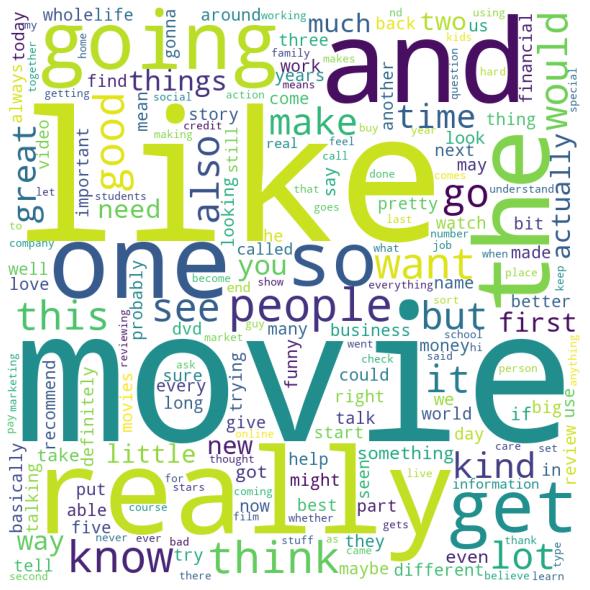

In [29]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', stopwords=stop_words,
                
                min_font_size = 10).generate_from_frequencies(wordcount)

plt.figure(figsize = (8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### nettoyage initial

In [20]:

""" 
def clean_text(text_file):
    cleaned_text = ''
    with open(src_dir+text_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            
            #timestamps en début de ligne
            stamp = re.search('.+___', line).group(0)
            
            #retrait des timestamps et élimine tous les "mots" qui sont en fait des nombres
            newline = ' '.join([word.lower() for word in line.strip(stamp).split() if (word.isalpha() and word not in stopwords_dict)]) + '\n'

            # méthode alternative pour retirer les charactères
            #newline = re.sub(r'[^\x00-\x7f]','',newline)

            #Tous les charactères non-ASCII sont retirés
            decoded_line = newline.encode(encoding='ascii', errors='ignore').decode()
            cleaned_text += decoded_line
    return cleaned_text
"""

def copy_clean_file(text_file, target_directory):
    with open(target_directory+text_file, 'w', encoding='utf-8') as f_out:
        f_out.write(clean_text(text_file))


def clean_corpus(source_directory, target_directory):
    for filename in list_filenames(source_directory):
        copy_clean_file(filename, target_directory)

#clean_corpus(src_dir, cleaned_dir)

## Modèles ML si on veut tester

In [21]:
count_vectorizer = CountVectorizer(input='filename',lowercase=False, ngram_range=(1,1))
count_vector = count_vectorizer.fit_transform(text_files)
#count_df = pd.DataFrame(count)


In [22]:
tfidf_vectorizer = TfidfVectorizer(input='filename')
tfidf_vector = tfidf_vectorizer.fit_transform(text_files)
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df

,00,000,0002267574___the,0004535147___71,0004535147___86,0009070295___last,0009070295___you,000907029___,000th,0011337868___what,...,ÿÿÿÿÿÿÿÿ,ÿÿÿÿÿÿÿÿÿÿÿÿ,ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿì,أسماء,ابكل,الناس,سعيد,عالسلامه,عام,نتمنالكم
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### TODO : pipelines clean +ML
### TODO : Train test split fichiers? randomize chq fois ou pre-split fichiers dans 3 folders

## DL Model
CNN?